# Complex source reconstruction at fixed lens mass

**HST mock data**

This notebooks gives a working example of the modelling of a complex and realistic source with a pixel-based method based on sparsity in _starlet_ domain (a specific type of wavelets). The lens mass model is assumed to be exactly known, and the source is reconstructed iteratively on a grid of pixel. The resulting surface brightness map is sparse in starlet space.

In [1]:
__author__ = 'aymgal'

import os
import copy
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
import time

from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
import lenstronomy.Util.util as lenstro_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Plots import lens_plot, chain_plot

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.plot_util import nice_colorbar, nice_colorbar_residuals, log_cmap
from slitronomy.Util import metrics_util

import fixed_param
import source_util

np.random.seed(18)

%matplotlib inline

## Some global parameters to play with

General parameters:
- `complex_source_type`: choice of the source galaxy among:
    - `'highres-single'`: a single galaxy from HST high-res image (same as Time Delay Lens Modelling Challenge mocks).
    - `'highres-satellite'`: two side-by-side galaxies from HST high-res images.
- `perfect_seeing`: if `True`, no PSF effect are included in simulation nor modelling.

The following parameters can be set for the **pixel-based reconstruction**:
- `solve_pixelbased`: if `True`, solves the source reconstruction problem on pixelated grid (e.g. starlets).
- `subgrid_res_source`: image pixel size to source pixel size ratio (aka subgrid resolution of source plane).

The following parameters can be set for the **analytical reconstruction**:
- `solve_analytical`: if `True`, solves with parametric profiles (e.g. shapelets).
- `n_max_source`: maximum order ($n_{\rm max}$) of shapelets basis set. The number of shapelets functions in the basis set is then $(n_{\rm max}+1)(n_{\rm max}+2)/2$.
- `n_max_source_2`: if not `None`, add a second shapelets basis set to the modelling with this maximum order.
- `optimizer_type`: `'SIMPLEX'` for a downhill simplex optimizer (faster), or `'PSO'` for a particle swarm optimizer (more efficient for large parameter space).

<div class="alert alert-warning">
Note: when reconstructing the source with the analytical method, one uses a downhill simplex non-linear optimizer for finding the bets-fit parameters. This speeds upt considerably the computation time, compared to a particle swarm optimization (PSO). However, when using two shapelets basis sets in the source model, the simplex method seems to fail at finding the global minimum, so a PSO is required in this case.
</div>

In [2]:
complex_source_type = 'highres-satellite'  # 'highres-single', 'highres-satellite'

solve_pixelbased = True
subgrid_res_source = 3
perfect_seeing = False

solve_analytical = True
n_max_source = 16
n_max_source_2 = 7
optimizer_type = 'SIMPLEX'  # 'SIMPLEX' or 'PSO'

In [3]:
# choice of colormaps for image plots
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = plt.get_cmap('cubehelix')
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.deepcopy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='gray', alpha=1)  # emphasize -negative pixels when in log scale

def get_HST_psf_kernel():
    with pf.open(os.path.join('data', 'PSFs', 'PSF_HST_F160W_tinytim.fits')) as f:
        psf_kernel = f[0].data
    # remove pixels near edges that display artifacts
    psf_kernel = psf_kernel[8:-8, 8:-8]
    # makes sure sum is 1
    psf_kernel /= psf_kernel.sum()
    return psf_kernel

## Define image size, resolution, seeing, and instrument properties

Instrument and observational setting inspired by J1537-3010 F160W science frame (after drizzling) and the WFC3/UR Exposure Time Calculator, for 4x500s exposures before drizzling.

However `'sky_brightness'` and `'magnitude_zero_point'` are taken from some defaults and may not be accurate

In [4]:
# data specifics
num_pix = 110  # number of side pixels
delta_pix = 0.08  # final pixel size in arcsec
num_pix_source = int(num_pix*subgrid_res_source)  # (maximum) number of side pixels for source plane

# seeing specifics
if perfect_seeing:
    psf_type = 'NONE'
    psf_kernel = None
else:
    psf_type = 'PIXEL'
    psf_kernel = get_HST_psf_kernel()


kwargs_HST_F160W = {
    # instrument-related
    #'read_noise': 80,  # std of noise generated by read-out (in units of electrons)
    'ccd_gain': 2.5,  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
    'pixel_scale': delta_pix,  # scale (in arcseonds) of pixels
    
    # observation-related
    #'sky_brightness': 21.7,  # sky brightness (in magnitude per square arcseconds)
    'exposure_time': 500,  # exposure time per image (in seconds)
    'magnitude_zero_point': 28,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
    'num_exposures': 4,  # number of exposures that are combined
    'data_count_unit': 'ADU',  # 'ADU' or 'e-'
    
    # or instead of 'read_noise' and 'sky_brightness'
    'background_noise': 0.1,
    
    'psf_type': psf_type,  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
    'kernel_point_source': psf_kernel  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
}

## Lens model, the source position and magnitude

Those parameters are common to HST mock data as well. They are defined on the `fixed_param` module.

In [5]:
# lens model properties
lens_model_list = fixed_param.lens_model_list  # list of profile names
kwargs_lens = fixed_param.kwargs_lens  # parameter values
lens_model_class = LensModel(lens_model_list=lens_model_list)

# main source galaxy properties
ra_source, dec_source = fixed_param.ra_source, fixed_param.dec_source
mag_source = fixed_param.mag_source

# secondary source galaxy properties (if 'satellite' source type), wrt to main source galaxy above
ra_source2, dec_source2 = fixed_param.ra_source-0.6, fixed_param.dec_source-0.4
mag_source2 = fixed_param.mag_source + 1

## Visualize lens model

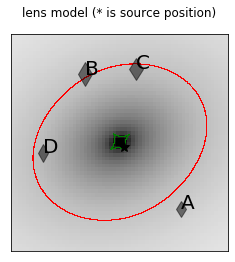

In [6]:
fig, ax = plt.subplots(1, 1)
ax.set_title("lens model (* is source position)")
lens_plot.lens_model_plot(ax, lens_model_class, kwargs_lens, 
                          numPix=60, deltaPix=0.08,   # play with these to zoom in/ou in the figure, or increase resolution
                          sourcePos_x=ra_source, sourcePos_y=dec_source,
                          point_source=True, with_caustics=True, coord_inverse=False)
plt.show()

## Setup the source surface brightness

This is performed in an external module. 

In [7]:
if complex_source_type == 'highres-single':
    source_model_list, kwargs_source = source_util.prepare_highres_source(ra_source, dec_source, 
                                                                          galaxy_name='NGC3982', 
                                                                          magnitude=mag_source)
elif complex_source_type == 'highres-satellite':
    source_model_list, kwargs_source = source_util.prepare_highres_source_multiple([(ra_source, dec_source), 
                                                                                    (ra_source2, dec_source2)], 
                                                                                   ['NGC3982', 'ESO498G5'],
                                                                                   [mag_source, mag_source2])

source_model_class = LightModel(light_model_list=source_model_list)

## Setup lens surface brightness

No lens light in this case.

In [8]:
#lens_light_model_list = []
#kwargs_lens_light = [{}]
#lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Simluate the image

### Build classes from the API, based on parameters above

In [9]:
# wrap up the model components
kwargs_model_sim = {
    'lens_model_list': lens_model_list,
    'source_light_model_list': source_model_list,
    #'lens_light_model_list': lens_light_model_list,
}

# instantiate the simulation class
sim_class = SimAPI(num_pix, kwargs_HST_F160W, kwargs_model_sim)

# get the image model class
imsim_class = sim_class.image_model_class(kwargs_numerics={'supersampling_factor': 3})

# get other useful classes
data_class = sim_class.data_class
psf_class = sim_class.psf_class

if 'magnitude' in kwargs_source[0]:
    # convert magnitudes into internal amplitude units based on instrumental settings
    print(kwargs_source[0]['magnitude'])
    _, kwargs_source, _ = sim_class.magnitude2amplitude(kwargs_source_mag=kwargs_source)
    print(kwargs_source[0]['amp'])

22
768.3877655160194


### Perform the actual simulation

In [10]:
# simulate the noise-free image
image_sim_no_noise = imsim_class.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

# add realistic noise
image_sim = image_sim_no_noise + sim_class.noise_for_model(model=image_sim_no_noise)

# update the data class with the simulated image
data_class.update_data(image_sim)

# one can also get the source light at the data resolution
source_sim_data_res = imsim_class.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=False)

# square root of noise covariance matrix
noise_map_sim = np.sqrt(data_class.C_D)

### Visualize products

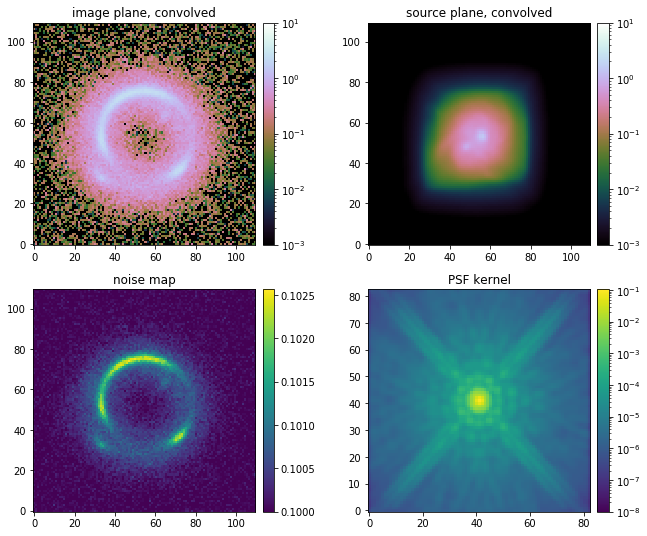

In [11]:
fig = plt.figure(figsize=(11, 9))

ax = plt.subplot(2, 2, 1)
ax.set_title("image plane, convolved")
im = ax.imshow(image_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-3, 1e1))
nice_colorbar(im)

ax = plt.subplot(2, 2, 2)
ax.set_title("source plane, convolved")
im = ax.imshow(source_sim_data_res, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-3, 1e1))
nice_colorbar(im)

ax = plt.subplot(2, 2, 3)
ax.set_title("noise map")
im = ax.imshow(noise_map_sim, origin='lower', cmap=cmap_default)
nice_colorbar(im)

ax = plt.subplot(2, 2, 4)
ax.set_title("PSF kernel")
im = ax.imshow(psf_class.kernel_point_source, origin='lower', 
               cmap=cmap_default, norm=LogNorm(1e-8))
nice_colorbar(im)

plt.show()

## Display higher resolution grid for source plane
### Extract coordinates grid arrays

In [12]:
# extract coordinates properties for orientation and pixel to angle conversion
ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
transform_pix2angle = data_class.transform_pix2angle

# from these properties, create grid objects for image plane and source plane
image_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
source_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0, 
                          supersampling_factor=subgrid_res_source)

# extract 1D coordinates arrays for easy evaluation surface brightness profiles
ra_grid, dec_grid = image_grid.coordinates_evaluate
ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

### Visualize true source surface brightness on higher resolution grid

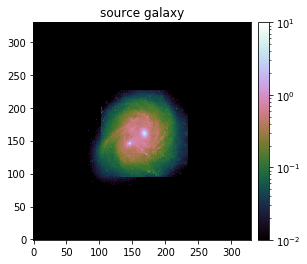

In [13]:
source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim = lenstro_util.array2image(source_sim)

# flux normalization of true source for proper comparison with pixel-based reconstruction
source_sim_comp = source_sim * delta_pix**2

plt.title("source galaxy")
im = plt.imshow(source_sim_comp, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)
plt.show()

## Reconstruction of the source galaxy

In [14]:
image_mask = np.ones_like(image_sim)  # you can set any mask on imaging data here (binary array, 0s are masked pixels)

### Pixel-based (sparse) reconstruction

In [15]:
# all results will be put in this dictionnary for final plot
all_results = {}
all_timings = {}

=== iteration 0-0 === : loss+reg = 514.9508|nan, red-chi2 = 8.2552|nan, step_diff = 38.4424|nan
=== iteration 1-0 === : loss+reg = 82.5847|nan, red-chi2 = 1.2855|nan, step_diff = 5.2098|nan
=== iteration 2-0 === : loss+reg = 73.2264|nan, red-chi2 = 1.1278|nan, step_diff = 5.1980|nan
Runtime : 2.921 s
Negative image pixels ? False (min = 3.10e-04)
Negative source pixels ? False (min = 0.00e+00)


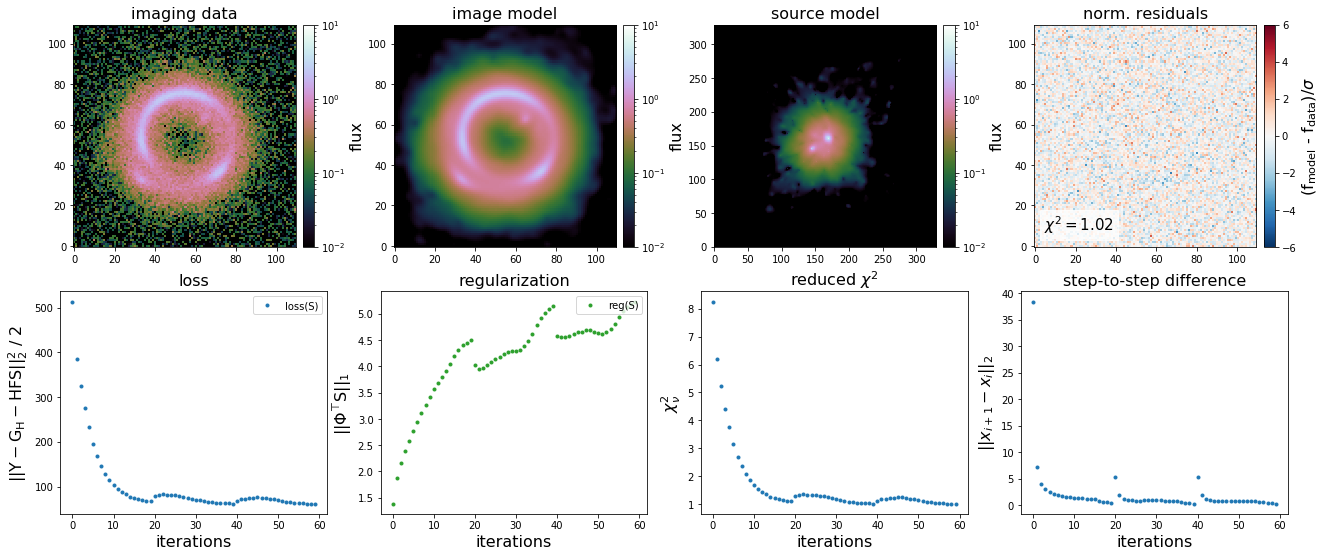

In [16]:
if solve_pixelbased:
    source_model_list_sparsefit = ['STARLETS']
    kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}
    kwargs_source_sparsefit = [kwargs_starlets_source]
    source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

    kwargs_special_sparsefit = {
        'delta_x_source_grid': 0,
        'delta_y_source_grid': 0,
    }

    kwargs_sparse_solver = {
        'include_regridding_error': False,
        'source_interpolation': 'bilinear',
        'subgrid_res_source': subgrid_res_source,
        'minimal_source_plane': False,
        'min_num_pix_source': 30,
        'min_threshold': 3,
        'threshold_increment_high_freq': 1,
        'threshold_decrease_type': 'exponential',
        'sparsity_prior_norm': 1,
        'num_iter_source': 20,
        'num_iter_weights': 3,
        'verbose': True,
        'show_steps': False,
        'thread_count': 8,  # number of processors
    }

    imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                    lens_model_class=lens_model_class,
                                    source_model_class=source_model_class_sparsefit,
                                    likelihood_mask=image_mask,
                                    kwargs_sparse_solver=kwargs_sparse_solver)
    
    # launch solver
    start_time = time.time()
    solver_results = imageSparseFit.image_sparse_solve(kwargs_lens, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=None,
                                                       kwargs_special=kwargs_special_sparsefit)
    end_time = time.time()
    all_timings['starlets'] = end_time-start_time
    print("Runtime : {:.3f} s".format(end_time-start_time))
    
    # display summary plot
    sparseSolver = imageSparseFit.sparseSolver
    fig = sparseSolver.plot_results(log_scale=True, fontsize=16,
                                    vmin_res=-6, vmax_res=6,
                                    vmin_image=10**(-2), vmax_image=10**(1), 
                                    vmin_source=10**(-2), vmax_source=10**(1))
    plt.show()
    
    # get model maps
    image_model = sparseSolver.image_model(unconvolved=False)
    source_model = sparseSolver.source_model
    # normalized_residuals = sparseSolver.normalized_residuals_model
    
    # use the following lines instead if a mask was used
    #source_model = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
    #source_model = lenstro_util.array2image(source_model)
    
    # save for comparison
    all_results['starlets'] = (image_model, source_model)
    
else:
    all_results['starlets'] = None
    all_timings['starlets'] = None

### Analytical reconstruction

Performing the optimization using algorithm: Nelder-Mead
1.0306855281092193 reduced X^2 of best position
-6139.2783481825645 logL
11913.0 effective number of data points
[{'theta_E': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'n_max': 16, 'beta': 0.1610771712354962, 'center_x': 0.09313641177906862, 'center_y': -0.03876259036399174}, {'amp': 1, 'n_max': 6, 'beta': 0.4895406170437162, 'center_x': -0.4920267256766403, 'center_y': -0.27933276878224733}] source result
[] lens light result
[] point source result
{} special param result
100.36267709732056 time used for  SIMPLEX
Runtime : 100.373 s
{'kwargs_lens': [{'theta_E': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'n_max': 16, 'beta': 0.1610771712354962, 'center_x': 0.09313641177906862, 'center_y': -0.03876259036399174}, {'amp': 1, 'n_max': 6

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Forked/lenstronomy_forked/lenstronomy/Plots/model_band_plot.py:87: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


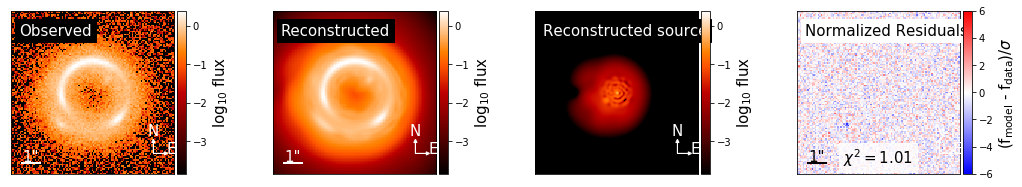

In [31]:
if solve_analytical:
    kwargs_numerics_fit = {'supersampling_factor': 3}
    kwargs_data_fit = {
        'image_data': data_class.data,
        'background_rms': sim_class.background_noise,
        'exposure_time': sim_class.scaled_exposure_time,
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
        'transform_pix2angle': transform_pix2angle,
    }
    kwargs_psf_fit = {
        'psf_type': psf_type,
        'kernel_point_source': psf_kernel,
    }

    kwargs_data_joint = {
        'multi_band_list': [[kwargs_data_fit, kwargs_psf_fit, kwargs_numerics_fit]],
        'multi_band_type': 'single-band',
    }
    kwargs_constraints = {
        'solver_type': 'NONE',
    }
    kwargs_likelihood = {
        'image_position_likelihood': True,
        'image_likelihood_mask_list': [image_mask],
    }

    # we fixed the mass to truth
    kwargs_lens_init = kwargs_lens
    kwargs_lens_fixed = kwargs_lens
    # dont'care about sigmas and bounds because lens mass is fixed here
    kwargs_lens_sigma = kwargs_lens  
    kwargs_lens_lower = kwargs_lens
    kwargs_lens_upper = kwargs_lens
    # setup for shapelets
    # we give the true source position as initial guess, initial beta should be close to the half light radius
    kwargs_source_init = [{'beta': 0.2, 'center_x': ra_source, 'center_y': dec_source}]
    kwargs_source_sigma = [{'beta': 0.05, 'center_x': 0.05, 'center_y': 0.05}]
    kwargs_source_fixed = [{'n_max': n_max_source}]
    kwargs_source_lower = [{'beta': 0.01, 'center_x': -3, 'center_y': -3}]
    kwargs_source_upper = [{'beta': 2, 'center_x': 3, 'center_y': 3}]
    source_light_model_list_fit = ['SHAPELETS']
    if n_max_source_2 is not None:
        source_light_model_list_fit.append('SHAPELETS')
        kwargs_source_init.append({'beta': 0.2, 'center_x': ra_source2, 'center_y': dec_source2})
        kwargs_source_sigma.append(kwargs_source_sigma[0])
        kwargs_source_lower.append(kwargs_source_lower[0])
        kwargs_source_upper.append(kwargs_source_upper[0])
        kwargs_source_fixed.append({'n_max': n_max_source_2})
    
    kwargs_model = {
        'lens_model_list': lens_model_list,
        'source_light_model_list': source_light_model_list_fit,
    }
    kwargs_params = {
        'lens_model': [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
        'source_model': [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper]
    }

    fitSequence = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                                  kwargs_likelihood, kwargs_params)
    
    # launch optimizer (single PSO)
    if optimizer_type == 'SIMPLEX':
        fitting_list = [
            ['SIMPLEX', {'n_iterations': 100, 'method': 'Nelder-Mead'}]
        ]
    elif optimizer_type == 'PSO':
        fitting_list = [
            ['PSO', {'n_particles': 20, 'n_iterations': 200, 'threadCount': 8}]
        ]
    start_time = time.time()
    chain_list = fitSequence.fit_sequence(fitting_list)
    end_time = time.time()
    all_timings['shapelets'] = end_time-start_time
    print("Runtime : {:.3f} s".format(end_time-start_time))
    
    # extract best-fit parameters
    kwargs_result = fitSequence.best_fit()
    print(kwargs_result)
    
    # check PSO convergence plot
    for i in range(len(chain_list)):
        if chain_list[i][0] == 'PSO':
            chain_plot.plot_chain_list(chain_list, i)

    modelPlot = ModelPlot(kwargs_data_joint['multi_band_list'], kwargs_model, kwargs_result, 
                          arrow_size=0.02, cmap_string="gist_heat")
    modelband = modelPlot._band_plot_list[0].bandmodel  # I know, bad practice to access private attribute here
    red_chi2 = modelPlot._band_plot_list[0]._reduced_x2
    #normalized_residuals = modelPlot._band_plot_list[0]._norm_residuals
        
    # get model maps
    image_model = modelband.image(**kwargs_result)
    source_model = LightModel(kwargs_model['source_light_model_list']).surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_result['kwargs_source'])
    source_model = lenstro_util.array2image(source_model)
    
    # display summary plots
    f, axes = plt.subplots(1, 4, figsize=(18, 3))
    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1])
    modelPlot.source_plot(ax=axes[2], deltaPix_source=delta_pix/subgrid_res_source, numPix=int(num_pix*subgrid_res_source))
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
    text = r"$\chi^2={:.2f}$".format(red_chi2)
    axes[3].text(0.5, 0.1, text, color='black', fontsize=15, 
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[3].transAxes, bbox={'color': 'white', 'alpha': 0.8})
    plt.show()
    
    # flux normalization of true source for proper comparison with pixel-based reconstruction
    source_model = source_model * subgrid_res_source**2 * (delta_pix/subgrid_res_source)**2
    
    # save for comparison
    all_results['shapelets'] = (image_model, source_model)

else:
    all_results['shapelets'] = None
    all_timings['shapelets'] = None
    

## Compare reconstructed source with groundtruth

min/max for source model 'starlets': 0.0/5.747914791107178
SDR for model 'starlets' = 7.765
min/max for source model 'shapelets': -0.023760069037467812/4.368083113095166
SDR for model 'shapelets' = 4.830


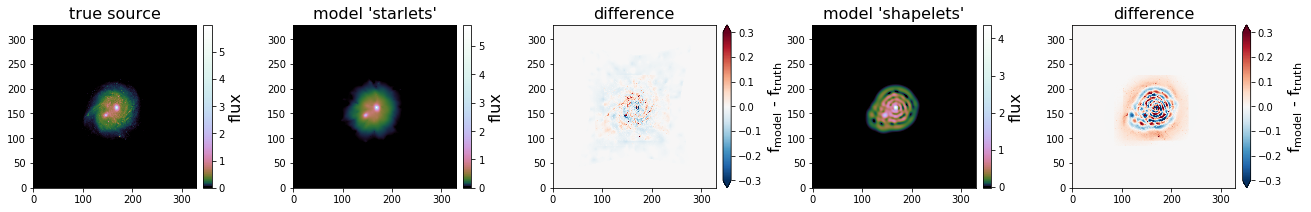

In [27]:
comparison_name_list = []
comparison_source_list = []
for model_type, results in all_results.items():
    comparison_name_list.append(model_type)
    comparison_source_list.append(results[1])

fig = sparseSolver.plot_source_residuals_comparison(source_sim_comp, comparison_source_list, comparison_name_list,
                                                    vmin_res=-0.3, vmax_res=0.3, fontsize=16,
                                                    cmap=log_cmap('cubehelix', 1e-2, 1))
plt.show()

## Compute some quality metrics

These quality metrics are defined in Joseph+19 (https://ui.adsabs.harvard.edu/abs/2019A%26A...623A..14J/abstract).
- QOR : Quality Of Residuals (image plane metric)
- SDR : Source Distortion Ratio (source plane metric)

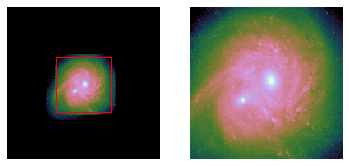

=== starlets ===
QOR = 1.0058606597434636
SDR = 7.764609064964413
SDR (restricted area) = 7.94091944194904
=== shapelets ===
QOR = 1.0068721608513955
SDR = 5.662581857294411
SDR (restricted area) = 5.723337176155391


In [32]:
# define a restricted area in source plane for SDR metric
idx_ll_x, idx_ll_y, width, height = 105, 100, 120, 120

# visualize the area
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.axis('off')
ax.imshow(source_sim_comp, origin='lower', cmap=log_cmap('cubehelix', 1e-3, 1))
rect = patches.Rectangle((idx_ll_x, idx_ll_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax = axes[1]
ax.axis('off')
ax.imshow(source_sim_comp[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width], origin='lower', cmap=log_cmap('cubehelix', 1e-3, 1))
plt.show()

# print metrics
all_sdr = {}
for model_type, results in all_results.items():
    if results is not None:
        print("=== {} ===".format(model_type))
        image_model, source_model = results
        
        print("QOR =", metrics_util.QOR(image_sim, image_model, noise_map_sim))

        print("SDR =", metrics_util.SDR(source_sim_comp, source_model))

        sdr_restric = metrics_util.SDR(source_model[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width], 
                                  source_sim_comp[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width])
        print("SDR (restricted area) =", sdr_restric)
        all_sdr[model_type] = sdr_restric
        

## Build a unified comparison plot

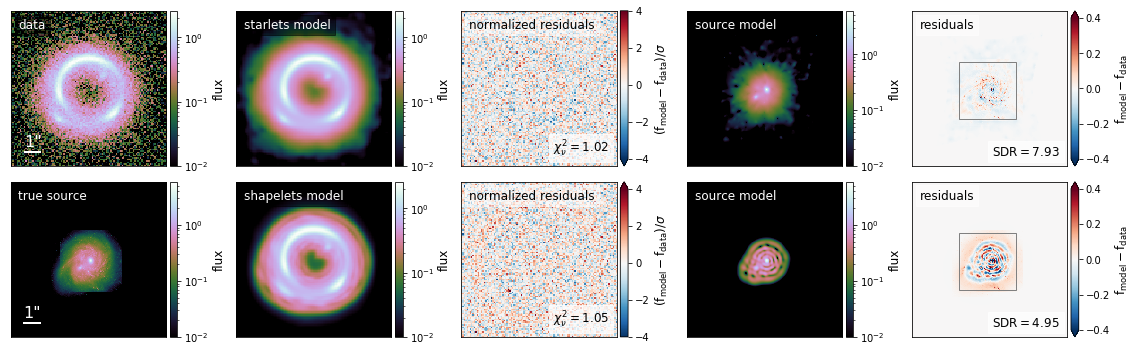

In [29]:
def add_scale_bar(ax, image_size, pixel_size, size_arcsec=1, color='white', fontsize=16):
    bott_left_x, bott_left_y = 0.08*image_size, 0.08*image_size
    width, height = float(size_arcsec)/pixel_size, 0.1/pixel_size
    bar = patches.Rectangle((bott_left_x, bott_left_y), width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 0.2/pixel_size
    text = '{}"'.format(size_arcsec)
    ax.text(bott_left_x+width/2., bott_left_y+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, fontsize=16, txt_color='black', bg_color='white'):
    ax.text(0.95, 0.05, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})


# flux value limits
image_vmin  = 10**(-2)
image_vmax  = image_sim.max() #* 10**(0.2)
source_vmin = 10**(-2)
source_vmax = source_sim_comp.max() #* 10**(0.2)

# residuals value limits (symmetric)
image_clim  = 4    # in noise units
source_clim = 0.4  # in (arbitrary) flux units

# setup the figure layout
num_results = len(all_results)
fig, axes = plt.subplots(num_results, 5, figsize=(20, 3*num_results))

# plot 0a: imaging data
ax = axes[0, 0]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "data", fontsize=12)
add_scale_bar(ax, num_pix, delta_pix)
im = ax.imshow(image_sim * image_mask, origin='lower', cmap=cmap_flux,
               norm=LogNorm(image_vmin, image_vmax))
nice_colorbar(im, label="flux", pad=0.05, fontsize=12)

# plot 0b: true source
ax = axes[1, 0]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "true source", fontsize=12)
add_scale_bar(ax, num_pix*subgrid_res_source, delta_pix/subgrid_res_source)
im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux,
               norm=LogNorm(source_vmin, source_vmax))
nice_colorbar(im, label="flux", pad=0.05, fontsize=12)

i = 0
for model_type, model_results in all_results.items():
    image_model, source_model = model_results
    
    # plot 1: image model
    ax = axes[i, 1]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "{} model".format(model_type), fontsize=12)
    im = ax.imshow(image_model * image_mask, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(image_vmin, image_vmax))
    nice_colorbar(im, label="flux", pad=0.05, fontsize=12)
    
    # plot 2: image normalized residuals
    image_red_res = (image_sim - image_model) / noise_map_sim * image_mask
    num_data_points = image_red_res[image_mask == 1].size
    ax = axes[i, 2]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "normalized residuals", fontsize=12, txt_color='black', bg_color='white')
    im = ax.imshow(image_red_res, origin='lower', cmap=cmap_residuals, 
                   vmin=-image_clim, vmax=image_clim)
    add_text_box(ax, r"$\chi^2_\nu=${:.2f}".format(metrics_util.chi2_nu(image_red_res, num_data_points)), fontsize=12)
    nice_colorbar_residuals(im, image_red_res, -image_clim, image_clim, pad=0.05, fontsize=12,
                            label=r"$({\rm f}_{\rm model}-{\rm f}_{\rm data})/\sigma$")
    
    # plot 3: source model
    ax = axes[i, 3]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "source model", fontsize=12)
    im = ax.imshow(source_model, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(source_vmin, source_vmax))
    nice_colorbar(im, label="flux", pad=0.05, fontsize=12)
    
    # plot 4: source residuals
    source_res = source_sim_comp - source_model
    ax = axes[i, 4]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "residuals", fontsize=12, txt_color='black', bg_color='white')
    im = ax.imshow(source_res, origin='lower', cmap=cmap_residuals, 
                   vmin=-source_clim, vmax=source_clim)
    rect = patches.Rectangle((idx_ll_x, idx_ll_y), width, height, linewidth=1, linestyle='-',
                             edgecolor='gray', facecolor='none')
    ax.add_patch(rect)
    add_text_box(ax, r"SDR$=${:.2f}".format(all_sdr[model_type]), fontsize=12)
    nice_colorbar_residuals(im, source_res, -source_clim, source_clim, pad=0.05, fontsize=12,
                            label=r"${\rm f}_{\rm model}-{\rm f}_{\rm data}$")
    i += 1

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)
plt.show()

<div class="alert alert-warning">
Warning: you can notice that residuals shown by lenstronomy routines are not equivalent to residuals of the above plot. This is because the (Poisson) noise covariance is computed differently: in the lenstronomy plotting routines, the noise covariance 
</div>

In [30]:
# save the figure
fig_name = 'mocksource_type-{}_ssres-{}_t-{:.1e}_nmax-{}-nmax2-{}_t-{:.1e}.pdf'.format(complex_source_type, subgrid_res_source,
                                                                                     all_timings['starlets'],
                                                                                     n_max_source, n_max_source_2,
                                                                                     all_timings['shapelets'],)
fig_path = os.path.join('figures', fig_name)
fig.savefig(fig_path, dpi=100, bbox_inches='tight')